In [2]:
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import copy
import torch
from torchvision import transforms as T
from torch.optim import lr_scheduler
import os
import math
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage import io
import umap
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torchvision.models as models
import splitfolders
print(device)

cpu


# Data preparation

In [7]:
# Data set class
class FaceDataset(Dataset):

    def __init__(self, image_dir, transform=None):
        
        """Function to load images into Tensor
            Args: 
                - image_dir : directory of images
                - Return : a dictonary with images and labels
        """
        self.image_dir = image_dir
        self.image_dict = self.load_image()
        self.transform = transform


    def __len__(self) :
        return len(self.image_dict["label"])


    def __getitem__(self, index) :
        
        
        path = torch.from_numpy(io.imread(self.image_dict["img_dir"][index],
                                         as_gray=False).astype(np.float32)).permute(2,0,1)
        label_bin = self.image_dict["label_bin"][index]
        label_to_token = self.image_dict["label"][index]

        if self.transform:
            img = path * 255.0
            img = torch.clip(img, 0.0, 255.0)
            img = img.type(torch.uint8)
            path = self.transform(img)
            path = path.type(torch.float32)#/path.max()
        
        return path, label_bin, label_to_token


    def load_image(self) :
        img_dict = {"img_dir" : [], "label" : [], 'label_bin':[]}
        label_to_int = {"real":0,"easy":1,"mid_":2,"hard":3}
        for root, dirs, files in os.walk(self.image_dir):
            for img in files:
                img_dict["img_dir"].append(os.path.join(root, img))
                
                img_dict["label"].append(label_to_int[img[:4]])
                if img[:4] != 'real':
                    img_dict["label_bin"].append(1.0)
                else:
                    img_dict["label_bin"].append(0.0)
        img_dict["label_bin"] = torch.tensor(img_dict["label_bin"],dtype=torch.float32)
        img_dict["label"] = torch.tensor(img_dict["label"],dtype=torch.float32)
        return img_dict

In [8]:
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

def plot_embeddings(X, y, title):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (10,10))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    
    return

In [9]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history[c])
        plt.legend(curves, loc='upper right')
        plt.show()

In [10]:
#splitfolders.ratio("./data", output="outputs",
    #seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [11]:
data = FaceDataset("./outputs/train")
valid_data = FaceDataset("./outputs/val")
test_data = FaceDataset("./outputs/test")

In [12]:
# Load with Dataset class
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET]
augmenters = [T.AutoAugment(policy) for policy in policies]

In [15]:
tf = T.Compose([#transforms.Resize((30,30)),
    #transforms.Grayscale(num_output_channels=1),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    #transforms.ToTensor()
    ])

In [14]:
imagnet_data = FaceDataset("./outputs/train",transform=augmenters[1])
cifar_data = FaceDataset("./outputs/train",transform=augmenters[0])

train_data = ConcatDataset([data, 
                               #cifar_data, 
                               imagnet_data
                              ])
len(train_data)

3264

In [44]:
train_data_loader = DataLoader(dataset= data,batch_size=10, shuffle=True, 
                               drop_last=True)
valid_data_loader = DataLoader(dataset= valid_data,batch_size=10, shuffle=True, 
                               drop_last=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=True, 
                              drop_last=True)

In [27]:
x =  0
total = 0
for _,label, _ in train_data_loader:
    x += label.sum()
    total += label.size(0)
print((total-x)/x)

tensor(1.1252)


In [158]:
transform = T.Compose([
T.Resize((30, 30))
])
transform(x).shape

torch.Size([3, 30, 30])

In [17]:
def build_model(name, fine_tune=True, num_classes=1):

    assert name in ("mobilenetv2", "efficientnet_b0")

    print('[INFO]: Loading pre-trained weights')
    if name =="mobilenetv2":
        model = models.mobilenet_v2(weights="DEFAULT")
    else:

        model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [36]:
model = build_model(name="efficientnet_b0", fine_tune=True, num_classes=1)

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [29]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm="gray", norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    fig.tight_layout(pad=0.8)
    plt.show()

In [30]:
def training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs,
                            loss_fn, learning_rate, verbose=True):

    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    model_tr.train()
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_acc, valid_loss = [], []
    transform = T.Resize(size = [224,224])
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels, _) in enumerate(train_dataloader):
            
            images = transform(images).to(device)
            # print(images.shape)
            labels = labels.to(device)
            y_pred = model_tr(images)
            l = loss_fn(y_pred, labels.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        
        scheduler.step() # Update the learning rate
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_cnn_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)
        if verbose:
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Test loss: {val_loss:.5f} | Test acc: {accuracy:.2f}%\n")
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

def eval_cnn_classifier(model, eval_dataloader,loss_fn):
    sigmoid = nn.Sigmoid()
    # Set the model in evaluation mode
    model.eval() 
    transform = T.Resize(size = [224,224])
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct,loss = 0, 0
        total = 0
        for images, labels,_ in eval_dataloader:
            
            images = transform(images).to(device)
            # print(images.shape)
            labels = labels.to(device)
            y_predicted = model(images)
            label_predicted = torch.round(sigmoid(y_predicted)).squeeze(1) #y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
            l =loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            loss += l.item()
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return loss, accuracy

- initial network with imagenet augmentation : acc 67%
- efficientnet with size 24, around 54%

In [32]:
model = model.to(device)
num_epochs = 30
learning_rate = 0.0001
loss_fn = nn.BCEWithLogitsLoss()
model_cnn, history= training_cnn_classifier(model, train_data_loader,valid_data_loader, num_epochs,
                            loss_fn, learning_rate, verbose=True)


Epoch [1/4]
Train loss: 227.34071 | Test loss: 13.98396 | Test acc: 50.00%


Epoch [2/4]
Train loss: 225.78653 | Test loss: 13.90058 | Test acc: 52.50%


Epoch [3/4]
Train loss: 223.02570 | Test loss: 13.83092 | Test acc: 53.50%


Epoch [4/4]
Train loss: 221.95032 | Test loss: 13.85360 | Test acc: 52.00%



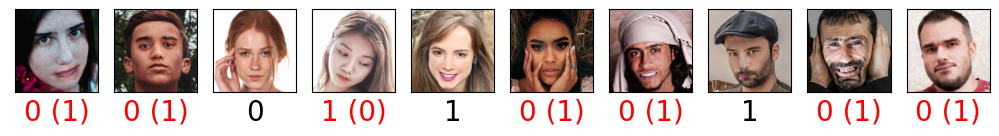

In [41]:
sigmoid = nn.Sigmoid()
x_test, y_test,_ = next(iter(test_data_loader))
transform_ = T.Resize(size = [30,30])
x_t = transform_(x_test)
y_pred = model_cnn(x_t)
y_test = y_test.numpy().astype(int)
y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().astype(int)
x_test = x_test.permute(0,2,3,1).squeeze().numpy()
plot_images(x_test/255, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)

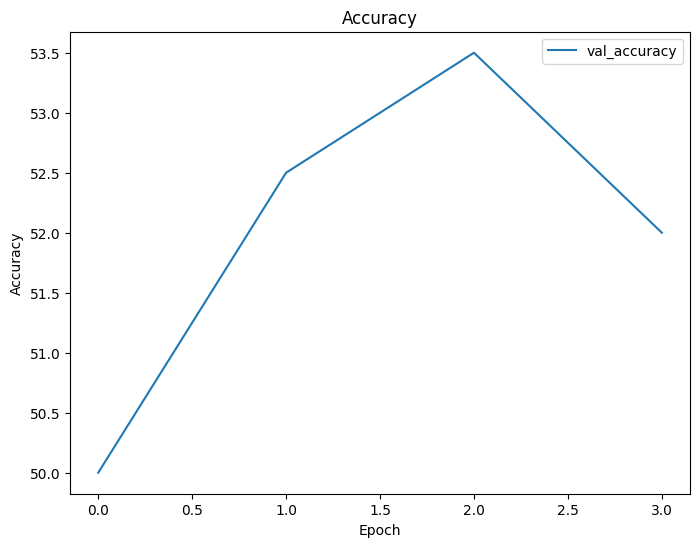

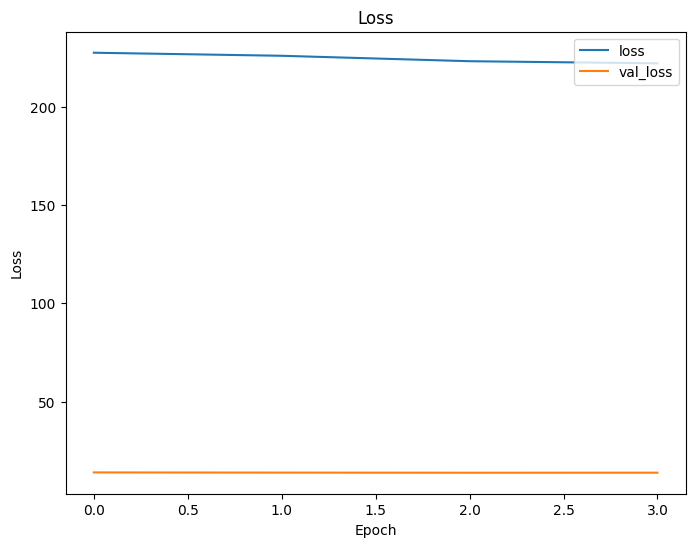

In [34]:
plot_history(history)

In [42]:
eval_cnn_classifier(model, test_data_loader, loss_fn)

(3064.4893255233765, 43.5)

In [45]:
model = build_model(name="mobilenetv2", fine_tune=True, num_classes=1)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
        

#torch.manual_seed(0)
# model.apply(init_weights)

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [46]:
model = model.to(device)
num_epochs = 10
learning_rate = 0.0001
loss_fn = nn.BCEWithLogitsLoss()
model_cnn, history= training_cnn_classifier(model, train_data_loader,valid_data_loader, num_epochs,
                            loss_fn, learning_rate, verbose=True)


Epoch [1/10]
Train loss: 113.96030 | Test loss: 13.90556 | Test acc: 49.00%


Epoch [2/10]
Train loss: 113.40268 | Test loss: 13.78846 | Test acc: 51.50%


Epoch [3/10]
Train loss: 112.53381 | Test loss: 13.74566 | Test acc: 55.00%


Epoch [4/10]
Train loss: 111.99192 | Test loss: 13.74537 | Test acc: 58.00%


Epoch [5/10]
Train loss: 111.58431 | Test loss: 13.69305 | Test acc: 59.00%


Epoch [6/10]
Train loss: 111.26260 | Test loss: 13.70148 | Test acc: 59.50%


Epoch [7/10]
Train loss: 110.93088 | Test loss: 13.70153 | Test acc: 58.50%


Epoch [8/10]
Train loss: 110.67861 | Test loss: 13.65008 | Test acc: 58.50%


Epoch [9/10]
Train loss: 110.47552 | Test loss: 13.66677 | Test acc: 59.00%


Epoch [10/10]
Train loss: 110.27195 | Test loss: 13.66100 | Test acc: 59.00%



In [47]:
eval_cnn_classifier(model, test_data_loader, loss_fn)

(13.866906642913818, 50.5)

In [48]:
sigmoid = nn.Sigmoid()
x_test, y_test,_ = next(iter(test_data_loader))
transform_ = T.Resize(size = [224,224])
x_t = transform_(x_test)
y_hat = model_cnn(x_t)
y_test = y_test
y_pred = torch.round(sigmoid(y_hat)).squeeze(1).detach().numpy().astype(int)

In [49]:
loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1.12))
loss(y_hat.squeeze(), y_test)

tensor(0.7230, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [157]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [174]:
transform_ = T.Resize(size = (30,30))
true_labels, pred_labels = [], []
for x, y in test_data_loader:
    x_t = transform_(x)
    y_pred = model_cnn(x_t)
    true_labels += y.tolist()
    prediction = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().tolist()
    pred_labels += prediction

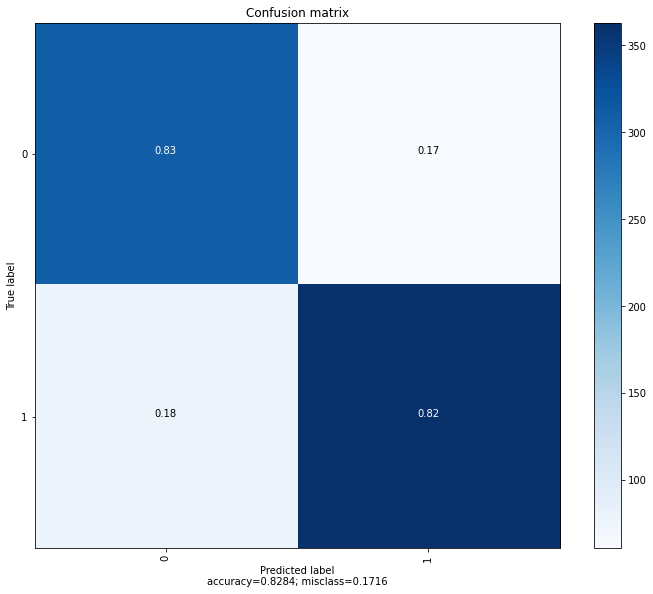

In [175]:
plot_confusion_matrix(y_true=np.array(true_labels),y_pred=np.array(pred_labels),
                          target_names=[0, 1])